### Prophet

In [1]:
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import pickle

In [2]:
def save_results(model_name, yhat, rmse, mape):
    # saving results
    with open('results.pickle', 'rb') as handle:
        results = pickle.load(handle)

    results['model'].append(model_name)
    results['values'].append(yhat)
    results['rmse'].append(rmse)
    results['mape'].append(mape)

    with open('results.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
df.rename(columns = {'date':'ds', 'price':'y'}, inplace = True)
# df.head(3)
forecast_size=30
train, test = df[:-forecast_size], df[-forecast_size:]

### Prophet - Forecasting without exogenous vairables

In [4]:
m = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.01).fit(train)
future = m.make_future_dataframe(periods=forecast_size)
forecast = m.predict(future)
yhat = forecast['yhat'][-forecast_size:]

21:53:50 - cmdstanpy - INFO - Chain [1] start processing
21:53:50 - cmdstanpy - INFO - Chain [1] done processing


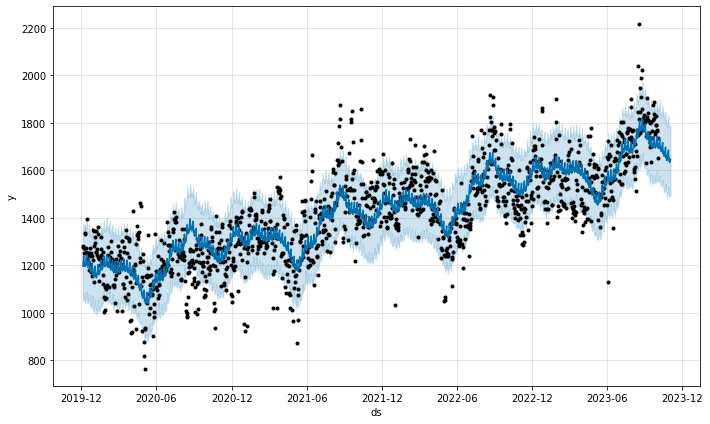

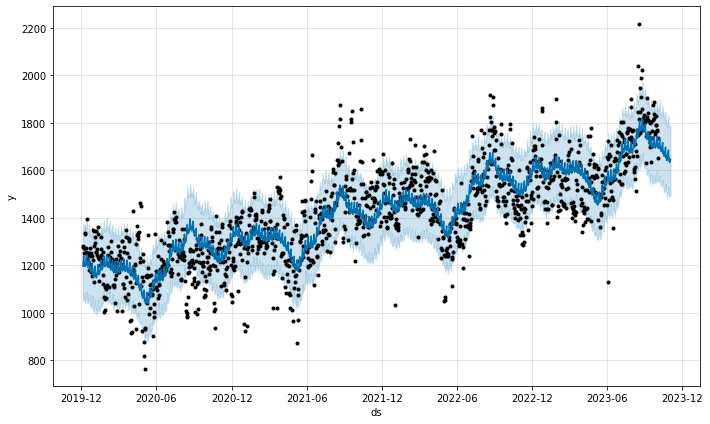

In [5]:
m.plot(forecast)

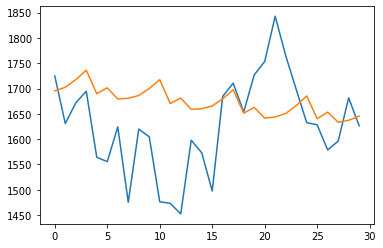

In [6]:
plt.plot(test['y'].to_list(), label = "True")
plt.plot(yhat.to_list(), label = "Forsted")

In [7]:
rmse_res = mse(test['y'], yhat, squared=False)
mape_res = mape(test['y'], yhat)
print("RMSE:", round(rmse_res, 2), "MAPE:", round(mape_res,3))

RMSE: 112.11 MAPE: 0.056


### Prophet - Forecasting neighbor prices

In [8]:
# Forecasting the neighbors prices
warnings.filterwarnings('ignore')
# preparing the dataset
df_x = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
df_x.drop(columns=['price', 'month', 'year', 'day_of_week'], axis=1, inplace=True)
df_x.rename(columns = {'date':'ds'}, inplace = True)
df_x.head(3)
x_nodes = df_x.columns.to_list()[1:] # getting the neighbors nodes names

In [9]:
# Forecasting the neighbors prices
warnings.filterwarnings('ignore')
# preparing the dataset
df_x = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
df_x.drop(columns=['price', 'month', 'year', 'day_of_week'], axis=1, inplace=True)
df_x.rename(columns = {'date':'ds'}, inplace = True)
df_x.head(3)
x_nodes = df_x.columns.to_list()[1:] # getting the neighbors nodes names

neighbor_predictions = {}

for node in x_nodes:
    df_x.rename(columns = {node:'y'}, inplace = True)
    train, test = df_x[:-forecast_size], df_x[-forecast_size:]
    m = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.01).fit(train)
    future = m.make_future_dataframe(periods=forecast_size, include_history = False)
    forecast = m.predict(future)
    neighbor_predictions[node] = forecast['yhat']
    rmse = mse(test['y'], forecast['yhat'], squared = False)
    print("Node:", node, "RMSE:", rmse)
    df_x.rename(columns = {'y':node}, inplace = True) # renaming the column back to it's name
#saving
import pickle
with open('neighbor_predictions_prophet.pickle', 'wb') as handle:
    pickle.dump(neighbor_predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] done processing


Node: 100414 RMSE: 107.09372474906758


21:53:54 - cmdstanpy - INFO - Chain [1] start processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing


Node: 100415 RMSE: 109.77468901906586


21:53:55 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1] done processing


Node: 100416 RMSE: 110.78626708780372


21:53:56 - cmdstanpy - INFO - Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] done processing


Node: 100442 RMSE: 110.77147695290991


21:53:57 - cmdstanpy - INFO - Chain [1] start processing
21:53:57 - cmdstanpy - INFO - Chain [1] done processing


Node: 100448 RMSE: 112.9375745237792


21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:58 - cmdstanpy - INFO - Chain [1] done processing


Node: 100458 RMSE: 112.29697778774644


21:53:58 - cmdstanpy - INFO - Chain [1] start processing
21:53:59 - cmdstanpy - INFO - Chain [1] done processing


Node: 100462 RMSE: 111.09017602351865


21:53:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing


Node: 100467 RMSE: 112.07365286128231


21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing


Node: 100476 RMSE: 111.41390246154074


21:54:01 - cmdstanpy - INFO - Chain [1] start processing
21:54:01 - cmdstanpy - INFO - Chain [1] done processing


Node: 101448 RMSE: 112.8600195896449


In [10]:
exogs = pd.DataFrame.from_dict(neighbor_predictions)

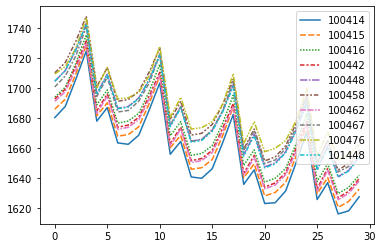

In [22]:
g = sns.lineplot(data=exogs)

### Forecasting main node price with forecasted exogs

In [12]:
train, test = df[:-forecast_size], df[-forecast_size:]
nodes = exogs.columns.to_list() # getting the neighbors nodes names
rmse_res = []

for i in range(0, len(nodes)):
    print('>>> working for:', nodes[i])
    m = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.01)
    # adding neighbour prices
    for k in range(i+1):
        m.add_regressor(nodes[k])
    m.fit(train)
    future = m.make_future_dataframe(periods=forecast_size, include_history=False)
    for k in range(i+1):
        future[nodes[k]] = exogs[nodes[k]].to_list()
    forecast = m.predict(future)
    rmse = mse(test['y'], forecast['yhat'], squared = False)
    rmse_res.append(rmse)
    print(rmse)

>>> working for: 100414


21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing


114.12954897777114
>>> working for: 100415


21:54:03 - cmdstanpy - INFO - Chain [1] start processing
21:54:04 - cmdstanpy - INFO - Chain [1] done processing


113.0527425020993
>>> working for: 100416


21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing


112.8136419211376
>>> working for: 100442


21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing


112.20249047196798
>>> working for: 100448


21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing


112.66813457156924
>>> working for: 100458


21:54:10 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing


112.59845728737405
>>> working for: 100462


21:54:13 - cmdstanpy - INFO - Chain [1] start processing
21:54:15 - cmdstanpy - INFO - Chain [1] done processing


112.68269691944737
>>> working for: 100467


21:54:15 - cmdstanpy - INFO - Chain [1] start processing
21:54:17 - cmdstanpy - INFO - Chain [1] done processing


112.37381568731598
>>> working for: 100476


21:54:18 - cmdstanpy - INFO - Chain [1] start processing
21:54:20 - cmdstanpy - INFO - Chain [1] done processing


112.39161558739818
>>> working for: 101448


21:54:21 - cmdstanpy - INFO - Chain [1] start processing
21:54:22 - cmdstanpy - INFO - Chain [1] done processing


112.36396090554048


In [13]:
rmse_res = mse(test['y'], forecast['yhat'], squared=False)
mape_res = mape(test['y'], forecast['yhat'])
print("RMSE:", round(rmse_res, 2), "MAPE:", round(mape_res,3))

RMSE: 112.36 MAPE: 0.056


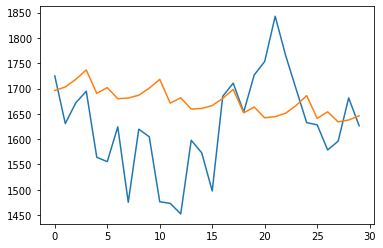

In [14]:
plt.plot(test['y'].to_list(), label = "True")
plt.plot(forecast['yhat'], label = "Forecasted")

In [15]:
# save_results("Prophet-1", forecasted_values.tolist(), rmse_res, mape_res)

### Prophet with lagged neighbour prices

In [16]:
def forecast_prophet_with_lagged_input (data, first_column_of_neighbor, lag):
    data = data.copy()
    data.rename(columns = {'date':'ds', 'price':'y'}, inplace = True)
    nodes = data.columns.to_list()[first_column_of_neighbor:]
    for node in nodes:
        data[node] = data[node].shift(lag)
    data.dropna(inplace=True)
    train, test = data[:-forecast_size], data[-forecast_size:]
    
    # Forecasting with all neighbours lagged
    m = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 0.01)
    for node in nodes:
        m.add_regressor(node)
    m.fit(train)
    future = m.make_future_dataframe(periods=forecast_size, include_history=False)
    for node in nodes:
        future[node] = test[node].to_list() #including test nodes as they are historical - shifted
    forecast = m.predict(future)
    rmse = mse(test['y'], forecast['yhat'], squared = False)
    mape_res = mape(test['y'], forecast['yhat'])
    print("Lag:",lag, "RMSE:", round(rmse,2), "MAPE:", round(mape_res, 3))
    return {'values': forecast['yhat'], 'rmse':rmse, 'mape':mape_res}

21:54:23 - cmdstanpy - INFO - Chain [1] start processing
21:54:23 - cmdstanpy - INFO - Chain [1] done processing


Lag: 366 RMSE: 120.82 MAPE: 0.059


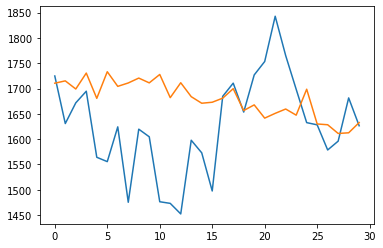

In [17]:
# Forecasting with lag = 366
df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
frcs = forecast_prophet_with_lagged_input(df, 5, 366)
plt.plot(test['y'].to_list(), label = "True")
plt.plot(frcs['values'], label = "Forecasted")

21:54:25 - cmdstanpy - INFO - Chain [1] start processing
21:54:25 - cmdstanpy - INFO - Chain [1] done processing


Lag: 63 RMSE: 102.75 MAPE: 0.051


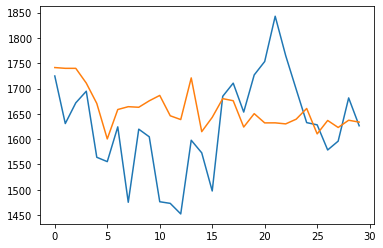

In [18]:
df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
frcs = forecast_prophet_with_lagged_input(df, 5, 63)
plt.plot(test['y'].to_list(), label = "True")
plt.plot(frcs['values'], label = "Forecasted")

### Cross-validation

### Bruteforcing the best lag

In [20]:
# looking for the best forecasting lag
p = {'lag':[],'rmse':[], 'mape':[]}
for i in range(30, 367):
    df = pd.read_csv("100419_main_input.csv", parse_dates = ['date'])
    frcs = forecast_prophet_with_lagged_input(df, 5, i)
    p['lag'].append(i)
    p['rmse'].append(frcs['rmse'])
    p['mape'].append(frcs['mape'])

21:56:44 - cmdstanpy - INFO - Chain [1] start processing
21:56:44 - cmdstanpy - INFO - Chain [1] done processing


Lag: 30 RMSE: 104.12 MAPE: 0.053


21:56:45 - cmdstanpy - INFO - Chain [1] start processing
21:56:45 - cmdstanpy - INFO - Chain [1] done processing


Lag: 31 RMSE: 107.34 MAPE: 0.054


21:56:46 - cmdstanpy - INFO - Chain [1] start processing
21:56:46 - cmdstanpy - INFO - Chain [1] done processing


Lag: 32 RMSE: 108.71 MAPE: 0.054


21:56:47 - cmdstanpy - INFO - Chain [1] start processing
21:56:47 - cmdstanpy - INFO - Chain [1] done processing


Lag: 33 RMSE: 109.22 MAPE: 0.053


21:56:48 - cmdstanpy - INFO - Chain [1] start processing
21:56:48 - cmdstanpy - INFO - Chain [1] done processing


Lag: 34 RMSE: 108.84 MAPE: 0.054


21:56:49 - cmdstanpy - INFO - Chain [1] start processing
21:56:49 - cmdstanpy - INFO - Chain [1] done processing


Lag: 35 RMSE: 109.31 MAPE: 0.055


21:56:50 - cmdstanpy - INFO - Chain [1] start processing
21:56:50 - cmdstanpy - INFO - Chain [1] done processing


Lag: 36 RMSE: 113.16 MAPE: 0.057


21:56:51 - cmdstanpy - INFO - Chain [1] start processing
21:56:51 - cmdstanpy - INFO - Chain [1] done processing


Lag: 37 RMSE: 112.47 MAPE: 0.056


21:56:52 - cmdstanpy - INFO - Chain [1] start processing
21:56:52 - cmdstanpy - INFO - Chain [1] done processing


Lag: 38 RMSE: 112.81 MAPE: 0.056


21:56:53 - cmdstanpy - INFO - Chain [1] start processing
21:56:53 - cmdstanpy - INFO - Chain [1] done processing


Lag: 39 RMSE: 113.78 MAPE: 0.057


21:56:54 - cmdstanpy - INFO - Chain [1] start processing
21:56:54 - cmdstanpy - INFO - Chain [1] done processing


Lag: 40 RMSE: 114.21 MAPE: 0.056


21:56:55 - cmdstanpy - INFO - Chain [1] start processing
21:56:55 - cmdstanpy - INFO - Chain [1] done processing


Lag: 41 RMSE: 112.48 MAPE: 0.056


21:56:56 - cmdstanpy - INFO - Chain [1] start processing
21:56:56 - cmdstanpy - INFO - Chain [1] done processing


Lag: 42 RMSE: 110.12 MAPE: 0.054


21:56:57 - cmdstanpy - INFO - Chain [1] start processing
21:56:57 - cmdstanpy - INFO - Chain [1] done processing


Lag: 43 RMSE: 107.47 MAPE: 0.052


21:56:58 - cmdstanpy - INFO - Chain [1] start processing
21:56:58 - cmdstanpy - INFO - Chain [1] done processing


Lag: 44 RMSE: 105.9 MAPE: 0.051


21:56:59 - cmdstanpy - INFO - Chain [1] start processing
21:56:59 - cmdstanpy - INFO - Chain [1] done processing


Lag: 45 RMSE: 106.86 MAPE: 0.052


21:57:00 - cmdstanpy - INFO - Chain [1] start processing
21:57:00 - cmdstanpy - INFO - Chain [1] done processing


Lag: 46 RMSE: 107.0 MAPE: 0.052


21:57:00 - cmdstanpy - INFO - Chain [1] start processing
21:57:01 - cmdstanpy - INFO - Chain [1] done processing


Lag: 47 RMSE: 107.12 MAPE: 0.053


21:57:01 - cmdstanpy - INFO - Chain [1] start processing
21:57:02 - cmdstanpy - INFO - Chain [1] done processing


Lag: 48 RMSE: 106.23 MAPE: 0.053


21:57:02 - cmdstanpy - INFO - Chain [1] start processing
21:57:03 - cmdstanpy - INFO - Chain [1] done processing


Lag: 49 RMSE: 106.2 MAPE: 0.054


21:57:03 - cmdstanpy - INFO - Chain [1] start processing
21:57:03 - cmdstanpy - INFO - Chain [1] done processing


Lag: 50 RMSE: 107.46 MAPE: 0.054


21:57:04 - cmdstanpy - INFO - Chain [1] start processing
21:57:04 - cmdstanpy - INFO - Chain [1] done processing


Lag: 51 RMSE: 118.14 MAPE: 0.058


21:57:05 - cmdstanpy - INFO - Chain [1] start processing
21:57:05 - cmdstanpy - INFO - Chain [1] done processing


Lag: 52 RMSE: 117.98 MAPE: 0.06


21:57:06 - cmdstanpy - INFO - Chain [1] start processing
21:57:06 - cmdstanpy - INFO - Chain [1] done processing


Lag: 53 RMSE: 117.05 MAPE: 0.059


21:57:07 - cmdstanpy - INFO - Chain [1] start processing
21:57:07 - cmdstanpy - INFO - Chain [1] done processing


Lag: 54 RMSE: 119.65 MAPE: 0.058


21:57:08 - cmdstanpy - INFO - Chain [1] start processing
21:57:09 - cmdstanpy - INFO - Chain [1] done processing


Lag: 55 RMSE: 120.23 MAPE: 0.058


21:57:09 - cmdstanpy - INFO - Chain [1] start processing
21:57:10 - cmdstanpy - INFO - Chain [1] done processing


Lag: 56 RMSE: 110.44 MAPE: 0.056


21:57:10 - cmdstanpy - INFO - Chain [1] start processing
21:57:11 - cmdstanpy - INFO - Chain [1] done processing


Lag: 57 RMSE: 115.9 MAPE: 0.057


21:57:11 - cmdstanpy - INFO - Chain [1] start processing
21:57:11 - cmdstanpy - INFO - Chain [1] done processing


Lag: 58 RMSE: 113.31 MAPE: 0.056


21:57:12 - cmdstanpy - INFO - Chain [1] start processing
21:57:12 - cmdstanpy - INFO - Chain [1] done processing


Lag: 59 RMSE: 109.73 MAPE: 0.054


21:57:13 - cmdstanpy - INFO - Chain [1] start processing
21:57:13 - cmdstanpy - INFO - Chain [1] done processing


Lag: 60 RMSE: 114.95 MAPE: 0.055


21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:14 - cmdstanpy - INFO - Chain [1] done processing


Lag: 61 RMSE: 110.19 MAPE: 0.053


21:57:15 - cmdstanpy - INFO - Chain [1] start processing
21:57:15 - cmdstanpy - INFO - Chain [1] done processing


Lag: 62 RMSE: 102.36 MAPE: 0.048


21:57:16 - cmdstanpy - INFO - Chain [1] start processing
21:57:16 - cmdstanpy - INFO - Chain [1] done processing


Lag: 63 RMSE: 102.75 MAPE: 0.051


21:57:17 - cmdstanpy - INFO - Chain [1] start processing
21:57:17 - cmdstanpy - INFO - Chain [1] done processing


Lag: 64 RMSE: 104.4 MAPE: 0.052


21:57:18 - cmdstanpy - INFO - Chain [1] start processing
21:57:18 - cmdstanpy - INFO - Chain [1] done processing


Lag: 65 RMSE: 105.04 MAPE: 0.052


21:57:18 - cmdstanpy - INFO - Chain [1] start processing
21:57:19 - cmdstanpy - INFO - Chain [1] done processing


Lag: 66 RMSE: 112.39 MAPE: 0.056


21:57:19 - cmdstanpy - INFO - Chain [1] start processing
21:57:20 - cmdstanpy - INFO - Chain [1] done processing


Lag: 67 RMSE: 108.49 MAPE: 0.055


21:57:20 - cmdstanpy - INFO - Chain [1] start processing
21:57:21 - cmdstanpy - INFO - Chain [1] done processing


Lag: 68 RMSE: 108.14 MAPE: 0.056


21:57:21 - cmdstanpy - INFO - Chain [1] start processing
21:57:22 - cmdstanpy - INFO - Chain [1] done processing


Lag: 69 RMSE: 113.48 MAPE: 0.056


21:57:22 - cmdstanpy - INFO - Chain [1] start processing
21:57:22 - cmdstanpy - INFO - Chain [1] done processing


Lag: 70 RMSE: 114.52 MAPE: 0.058


21:57:23 - cmdstanpy - INFO - Chain [1] start processing
21:57:23 - cmdstanpy - INFO - Chain [1] done processing


Lag: 71 RMSE: 111.42 MAPE: 0.057


21:57:24 - cmdstanpy - INFO - Chain [1] start processing
21:57:24 - cmdstanpy - INFO - Chain [1] done processing


Lag: 72 RMSE: 111.45 MAPE: 0.055


21:57:25 - cmdstanpy - INFO - Chain [1] start processing
21:57:25 - cmdstanpy - INFO - Chain [1] done processing


Lag: 73 RMSE: 112.09 MAPE: 0.055


21:57:26 - cmdstanpy - INFO - Chain [1] start processing
21:57:26 - cmdstanpy - INFO - Chain [1] done processing


Lag: 74 RMSE: 113.41 MAPE: 0.058


21:57:26 - cmdstanpy - INFO - Chain [1] start processing
21:57:27 - cmdstanpy - INFO - Chain [1] done processing


Lag: 75 RMSE: 118.98 MAPE: 0.059


21:57:27 - cmdstanpy - INFO - Chain [1] start processing
21:57:28 - cmdstanpy - INFO - Chain [1] done processing


Lag: 76 RMSE: 122.82 MAPE: 0.063


21:57:28 - cmdstanpy - INFO - Chain [1] start processing
21:57:29 - cmdstanpy - INFO - Chain [1] done processing


Lag: 77 RMSE: 128.77 MAPE: 0.064


21:57:29 - cmdstanpy - INFO - Chain [1] start processing
21:57:30 - cmdstanpy - INFO - Chain [1] done processing


Lag: 78 RMSE: 140.44 MAPE: 0.07


21:57:30 - cmdstanpy - INFO - Chain [1] start processing
21:57:31 - cmdstanpy - INFO - Chain [1] done processing


Lag: 79 RMSE: 139.34 MAPE: 0.068


21:57:31 - cmdstanpy - INFO - Chain [1] start processing
21:57:32 - cmdstanpy - INFO - Chain [1] done processing


Lag: 80 RMSE: 125.3 MAPE: 0.062


21:57:33 - cmdstanpy - INFO - Chain [1] start processing
21:57:33 - cmdstanpy - INFO - Chain [1] done processing


Lag: 81 RMSE: 115.97 MAPE: 0.056


21:57:34 - cmdstanpy - INFO - Chain [1] start processing
21:57:34 - cmdstanpy - INFO - Chain [1] done processing


Lag: 82 RMSE: 112.89 MAPE: 0.055


21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing


Lag: 83 RMSE: 116.04 MAPE: 0.058


21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing


Lag: 84 RMSE: 112.67 MAPE: 0.055


21:57:37 - cmdstanpy - INFO - Chain [1] start processing
21:57:37 - cmdstanpy - INFO - Chain [1] done processing


Lag: 85 RMSE: 109.43 MAPE: 0.054


21:57:38 - cmdstanpy - INFO - Chain [1] start processing
21:57:38 - cmdstanpy - INFO - Chain [1] done processing


Lag: 86 RMSE: 110.08 MAPE: 0.054


21:57:39 - cmdstanpy - INFO - Chain [1] start processing
21:57:39 - cmdstanpy - INFO - Chain [1] done processing


Lag: 87 RMSE: 117.04 MAPE: 0.059


21:57:40 - cmdstanpy - INFO - Chain [1] start processing
21:57:40 - cmdstanpy - INFO - Chain [1] done processing


Lag: 88 RMSE: 112.73 MAPE: 0.057


21:57:40 - cmdstanpy - INFO - Chain [1] start processing
21:57:41 - cmdstanpy - INFO - Chain [1] done processing


Lag: 89 RMSE: 118.77 MAPE: 0.061


21:57:41 - cmdstanpy - INFO - Chain [1] start processing
21:57:42 - cmdstanpy - INFO - Chain [1] done processing


Lag: 90 RMSE: 117.15 MAPE: 0.061


21:57:42 - cmdstanpy - INFO - Chain [1] start processing
21:57:42 - cmdstanpy - INFO - Chain [1] done processing


Lag: 91 RMSE: 119.51 MAPE: 0.063


21:57:43 - cmdstanpy - INFO - Chain [1] start processing
21:57:43 - cmdstanpy - INFO - Chain [1] done processing


Lag: 92 RMSE: 126.49 MAPE: 0.069


21:57:44 - cmdstanpy - INFO - Chain [1] start processing
21:57:44 - cmdstanpy - INFO - Chain [1] done processing


Lag: 93 RMSE: 127.37 MAPE: 0.069


21:57:45 - cmdstanpy - INFO - Chain [1] start processing
21:57:45 - cmdstanpy - INFO - Chain [1] done processing


Lag: 94 RMSE: 128.28 MAPE: 0.068


21:57:46 - cmdstanpy - INFO - Chain [1] start processing
21:57:46 - cmdstanpy - INFO - Chain [1] done processing


Lag: 95 RMSE: 128.55 MAPE: 0.068


21:57:46 - cmdstanpy - INFO - Chain [1] start processing
21:57:47 - cmdstanpy - INFO - Chain [1] done processing


Lag: 96 RMSE: 121.74 MAPE: 0.064


21:57:47 - cmdstanpy - INFO - Chain [1] start processing
21:57:48 - cmdstanpy - INFO - Chain [1] done processing


Lag: 97 RMSE: 119.74 MAPE: 0.062


21:57:48 - cmdstanpy - INFO - Chain [1] start processing
21:57:48 - cmdstanpy - INFO - Chain [1] done processing


Lag: 98 RMSE: 120.23 MAPE: 0.061


21:57:49 - cmdstanpy - INFO - Chain [1] start processing
21:57:49 - cmdstanpy - INFO - Chain [1] done processing


Lag: 99 RMSE: 122.77 MAPE: 0.061


21:57:50 - cmdstanpy - INFO - Chain [1] start processing
21:57:50 - cmdstanpy - INFO - Chain [1] done processing


Lag: 100 RMSE: 119.63 MAPE: 0.061


21:57:51 - cmdstanpy - INFO - Chain [1] start processing
21:57:51 - cmdstanpy - INFO - Chain [1] done processing


Lag: 101 RMSE: 120.81 MAPE: 0.062


21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:52 - cmdstanpy - INFO - Chain [1] done processing


Lag: 102 RMSE: 122.78 MAPE: 0.062


21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:53 - cmdstanpy - INFO - Chain [1] done processing


Lag: 103 RMSE: 120.68 MAPE: 0.06


21:57:53 - cmdstanpy - INFO - Chain [1] start processing
21:57:54 - cmdstanpy - INFO - Chain [1] done processing


Lag: 104 RMSE: 114.32 MAPE: 0.057


21:57:54 - cmdstanpy - INFO - Chain [1] start processing
21:57:55 - cmdstanpy - INFO - Chain [1] done processing


Lag: 105 RMSE: 117.05 MAPE: 0.059


21:57:55 - cmdstanpy - INFO - Chain [1] start processing
21:57:56 - cmdstanpy - INFO - Chain [1] done processing


Lag: 106 RMSE: 115.17 MAPE: 0.058


21:57:56 - cmdstanpy - INFO - Chain [1] start processing
21:57:57 - cmdstanpy - INFO - Chain [1] done processing


Lag: 107 RMSE: 117.24 MAPE: 0.058


21:57:57 - cmdstanpy - INFO - Chain [1] start processing
21:57:57 - cmdstanpy - INFO - Chain [1] done processing


Lag: 108 RMSE: 119.8 MAPE: 0.06


21:57:58 - cmdstanpy - INFO - Chain [1] start processing
21:57:58 - cmdstanpy - INFO - Chain [1] done processing


Lag: 109 RMSE: 117.73 MAPE: 0.059


21:57:59 - cmdstanpy - INFO - Chain [1] start processing
21:57:59 - cmdstanpy - INFO - Chain [1] done processing


Lag: 110 RMSE: 118.95 MAPE: 0.059


21:58:00 - cmdstanpy - INFO - Chain [1] start processing
21:58:00 - cmdstanpy - INFO - Chain [1] done processing


Lag: 111 RMSE: 119.36 MAPE: 0.059


21:58:01 - cmdstanpy - INFO - Chain [1] start processing
21:58:01 - cmdstanpy - INFO - Chain [1] done processing


Lag: 112 RMSE: 114.33 MAPE: 0.057


21:58:02 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1] done processing


Lag: 113 RMSE: 116.73 MAPE: 0.059


21:58:03 - cmdstanpy - INFO - Chain [1] start processing
21:58:03 - cmdstanpy - INFO - Chain [1] done processing


Lag: 114 RMSE: 111.99 MAPE: 0.056


21:58:04 - cmdstanpy - INFO - Chain [1] start processing
21:58:04 - cmdstanpy - INFO - Chain [1] done processing


Lag: 115 RMSE: 111.1 MAPE: 0.055


21:58:04 - cmdstanpy - INFO - Chain [1] start processing
21:58:05 - cmdstanpy - INFO - Chain [1] done processing


Lag: 116 RMSE: 110.81 MAPE: 0.055


21:58:05 - cmdstanpy - INFO - Chain [1] start processing
21:58:06 - cmdstanpy - INFO - Chain [1] done processing


Lag: 117 RMSE: 109.56 MAPE: 0.054


21:58:06 - cmdstanpy - INFO - Chain [1] start processing
21:58:06 - cmdstanpy - INFO - Chain [1] done processing


Lag: 118 RMSE: 108.85 MAPE: 0.054


21:58:07 - cmdstanpy - INFO - Chain [1] start processing
21:58:07 - cmdstanpy - INFO - Chain [1] done processing


Lag: 119 RMSE: 108.38 MAPE: 0.054


21:58:08 - cmdstanpy - INFO - Chain [1] start processing
21:58:08 - cmdstanpy - INFO - Chain [1] done processing


Lag: 120 RMSE: 107.93 MAPE: 0.054


21:58:09 - cmdstanpy - INFO - Chain [1] start processing
21:58:09 - cmdstanpy - INFO - Chain [1] done processing


Lag: 121 RMSE: 106.84 MAPE: 0.053


21:58:10 - cmdstanpy - INFO - Chain [1] start processing
21:58:10 - cmdstanpy - INFO - Chain [1] done processing


Lag: 122 RMSE: 108.15 MAPE: 0.054


21:58:11 - cmdstanpy - INFO - Chain [1] start processing
21:58:11 - cmdstanpy - INFO - Chain [1] done processing


Lag: 123 RMSE: 108.89 MAPE: 0.054


21:58:12 - cmdstanpy - INFO - Chain [1] start processing
21:58:12 - cmdstanpy - INFO - Chain [1] done processing


Lag: 124 RMSE: 125.16 MAPE: 0.061


21:58:13 - cmdstanpy - INFO - Chain [1] start processing
21:58:13 - cmdstanpy - INFO - Chain [1] done processing


Lag: 125 RMSE: 130.63 MAPE: 0.061


21:58:14 - cmdstanpy - INFO - Chain [1] start processing
21:58:14 - cmdstanpy - INFO - Chain [1] done processing


Lag: 126 RMSE: 116.36 MAPE: 0.059


21:58:14 - cmdstanpy - INFO - Chain [1] start processing
21:58:15 - cmdstanpy - INFO - Chain [1] done processing


Lag: 127 RMSE: 125.68 MAPE: 0.062


21:58:15 - cmdstanpy - INFO - Chain [1] start processing
21:58:16 - cmdstanpy - INFO - Chain [1] done processing


Lag: 128 RMSE: 125.2 MAPE: 0.061


21:58:16 - cmdstanpy - INFO - Chain [1] start processing
21:58:17 - cmdstanpy - INFO - Chain [1] done processing


Lag: 129 RMSE: 118.33 MAPE: 0.059


21:58:17 - cmdstanpy - INFO - Chain [1] start processing
21:58:18 - cmdstanpy - INFO - Chain [1] done processing


Lag: 130 RMSE: 120.12 MAPE: 0.061


21:58:18 - cmdstanpy - INFO - Chain [1] start processing
21:58:19 - cmdstanpy - INFO - Chain [1] done processing


Lag: 131 RMSE: 131.81 MAPE: 0.062


21:58:19 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing


Lag: 132 RMSE: 141.98 MAPE: 0.067


21:58:20 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing


Lag: 133 RMSE: 146.65 MAPE: 0.067


21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:21 - cmdstanpy - INFO - Chain [1] done processing


Lag: 134 RMSE: 153.05 MAPE: 0.066


21:58:22 - cmdstanpy - INFO - Chain [1] start processing
21:58:22 - cmdstanpy - INFO - Chain [1] done processing


Lag: 135 RMSE: 138.53 MAPE: 0.063


21:58:23 - cmdstanpy - INFO - Chain [1] start processing
21:58:23 - cmdstanpy - INFO - Chain [1] done processing


Lag: 136 RMSE: 118.16 MAPE: 0.058


21:58:24 - cmdstanpy - INFO - Chain [1] start processing
21:58:24 - cmdstanpy - INFO - Chain [1] done processing


Lag: 137 RMSE: 123.16 MAPE: 0.06


21:58:24 - cmdstanpy - INFO - Chain [1] start processing
21:58:25 - cmdstanpy - INFO - Chain [1] done processing


Lag: 138 RMSE: 123.35 MAPE: 0.06


21:58:25 - cmdstanpy - INFO - Chain [1] start processing
21:58:25 - cmdstanpy - INFO - Chain [1] done processing


Lag: 139 RMSE: 121.1 MAPE: 0.059


21:58:26 - cmdstanpy - INFO - Chain [1] start processing
21:58:26 - cmdstanpy - INFO - Chain [1] done processing


Lag: 140 RMSE: 136.33 MAPE: 0.063


21:58:27 - cmdstanpy - INFO - Chain [1] start processing
21:58:27 - cmdstanpy - INFO - Chain [1] done processing


Lag: 141 RMSE: 128.72 MAPE: 0.06


21:58:28 - cmdstanpy - INFO - Chain [1] start processing
21:58:28 - cmdstanpy - INFO - Chain [1] done processing


Lag: 142 RMSE: 161.4 MAPE: 0.068


21:58:29 - cmdstanpy - INFO - Chain [1] start processing
21:58:29 - cmdstanpy - INFO - Chain [1] done processing


Lag: 143 RMSE: 110.2 MAPE: 0.054


21:58:30 - cmdstanpy - INFO - Chain [1] start processing
21:58:30 - cmdstanpy - INFO - Chain [1] done processing


Lag: 144 RMSE: 107.11 MAPE: 0.053


21:58:30 - cmdstanpy - INFO - Chain [1] start processing
21:58:31 - cmdstanpy - INFO - Chain [1] done processing


Lag: 145 RMSE: 103.36 MAPE: 0.051


21:58:31 - cmdstanpy - INFO - Chain [1] start processing
21:58:32 - cmdstanpy - INFO - Chain [1] done processing


Lag: 146 RMSE: 102.5 MAPE: 0.051


21:58:32 - cmdstanpy - INFO - Chain [1] start processing
21:58:32 - cmdstanpy - INFO - Chain [1] done processing


Lag: 147 RMSE: 109.93 MAPE: 0.056


21:58:33 - cmdstanpy - INFO - Chain [1] start processing
21:58:33 - cmdstanpy - INFO - Chain [1] done processing


Lag: 148 RMSE: 121.43 MAPE: 0.061


21:58:34 - cmdstanpy - INFO - Chain [1] start processing
21:58:34 - cmdstanpy - INFO - Chain [1] done processing


Lag: 149 RMSE: 123.4 MAPE: 0.063


21:58:35 - cmdstanpy - INFO - Chain [1] start processing
21:58:35 - cmdstanpy - INFO - Chain [1] done processing


Lag: 150 RMSE: 115.52 MAPE: 0.058


21:58:36 - cmdstanpy - INFO - Chain [1] start processing
21:58:36 - cmdstanpy - INFO - Chain [1] done processing


Lag: 151 RMSE: 119.26 MAPE: 0.06


21:58:37 - cmdstanpy - INFO - Chain [1] start processing
21:58:37 - cmdstanpy - INFO - Chain [1] done processing


Lag: 152 RMSE: 120.82 MAPE: 0.062


21:58:38 - cmdstanpy - INFO - Chain [1] start processing
21:58:38 - cmdstanpy - INFO - Chain [1] done processing


Lag: 153 RMSE: 120.93 MAPE: 0.062


21:58:39 - cmdstanpy - INFO - Chain [1] start processing
21:58:39 - cmdstanpy - INFO - Chain [1] done processing


Lag: 154 RMSE: 126.06 MAPE: 0.064


21:58:40 - cmdstanpy - INFO - Chain [1] start processing
21:58:40 - cmdstanpy - INFO - Chain [1] done processing


Lag: 155 RMSE: 124.77 MAPE: 0.063


21:58:41 - cmdstanpy - INFO - Chain [1] start processing
21:58:41 - cmdstanpy - INFO - Chain [1] done processing


Lag: 156 RMSE: 116.74 MAPE: 0.058


21:58:42 - cmdstanpy - INFO - Chain [1] start processing
21:58:42 - cmdstanpy - INFO - Chain [1] done processing


Lag: 157 RMSE: 113.15 MAPE: 0.056


21:58:43 - cmdstanpy - INFO - Chain [1] start processing
21:58:43 - cmdstanpy - INFO - Chain [1] done processing


Lag: 158 RMSE: 114.19 MAPE: 0.056


21:58:43 - cmdstanpy - INFO - Chain [1] start processing
21:58:44 - cmdstanpy - INFO - Chain [1] done processing


Lag: 159 RMSE: 111.5 MAPE: 0.055


21:58:44 - cmdstanpy - INFO - Chain [1] start processing
21:58:45 - cmdstanpy - INFO - Chain [1] done processing


Lag: 160 RMSE: 110.53 MAPE: 0.055


21:58:45 - cmdstanpy - INFO - Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1] done processing


Lag: 161 RMSE: 110.49 MAPE: 0.055


21:58:46 - cmdstanpy - INFO - Chain [1] start processing
21:58:47 - cmdstanpy - INFO - Chain [1] done processing


Lag: 162 RMSE: 111.29 MAPE: 0.055


21:58:47 - cmdstanpy - INFO - Chain [1] start processing
21:58:48 - cmdstanpy - INFO - Chain [1] done processing


Lag: 163 RMSE: 108.06 MAPE: 0.052


21:58:48 - cmdstanpy - INFO - Chain [1] start processing
21:58:49 - cmdstanpy - INFO - Chain [1] done processing


Lag: 164 RMSE: 109.85 MAPE: 0.054


21:58:49 - cmdstanpy - INFO - Chain [1] start processing
21:58:49 - cmdstanpy - INFO - Chain [1] done processing


Lag: 165 RMSE: 110.48 MAPE: 0.055


21:58:50 - cmdstanpy - INFO - Chain [1] start processing
21:58:50 - cmdstanpy - INFO - Chain [1] done processing


Lag: 166 RMSE: 111.84 MAPE: 0.055


21:58:51 - cmdstanpy - INFO - Chain [1] start processing
21:58:51 - cmdstanpy - INFO - Chain [1] done processing


Lag: 167 RMSE: 113.42 MAPE: 0.056


21:58:51 - cmdstanpy - INFO - Chain [1] start processing
21:58:52 - cmdstanpy - INFO - Chain [1] done processing


Lag: 168 RMSE: 111.65 MAPE: 0.056


21:58:52 - cmdstanpy - INFO - Chain [1] start processing
21:58:52 - cmdstanpy - INFO - Chain [1] done processing


Lag: 169 RMSE: 113.87 MAPE: 0.057


21:58:53 - cmdstanpy - INFO - Chain [1] start processing
21:58:53 - cmdstanpy - INFO - Chain [1] done processing


Lag: 170 RMSE: 113.32 MAPE: 0.057


21:58:54 - cmdstanpy - INFO - Chain [1] start processing
21:58:54 - cmdstanpy - INFO - Chain [1] done processing


Lag: 171 RMSE: 114.12 MAPE: 0.057


21:58:55 - cmdstanpy - INFO - Chain [1] start processing
21:58:55 - cmdstanpy - INFO - Chain [1] done processing


Lag: 172 RMSE: 111.46 MAPE: 0.056


21:58:55 - cmdstanpy - INFO - Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing


Lag: 173 RMSE: 113.04 MAPE: 0.057


21:58:56 - cmdstanpy - INFO - Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing


Lag: 174 RMSE: 113.63 MAPE: 0.057


21:58:57 - cmdstanpy - INFO - Chain [1] start processing
21:58:57 - cmdstanpy - INFO - Chain [1] done processing


Lag: 175 RMSE: 113.01 MAPE: 0.056


21:58:58 - cmdstanpy - INFO - Chain [1] start processing
21:58:58 - cmdstanpy - INFO - Chain [1] done processing


Lag: 176 RMSE: 113.5 MAPE: 0.057


21:58:59 - cmdstanpy - INFO - Chain [1] start processing
21:58:59 - cmdstanpy - INFO - Chain [1] done processing


Lag: 177 RMSE: 106.29 MAPE: 0.052


21:59:00 - cmdstanpy - INFO - Chain [1] start processing
21:59:00 - cmdstanpy - INFO - Chain [1] done processing


Lag: 178 RMSE: 110.12 MAPE: 0.054


21:59:00 - cmdstanpy - INFO - Chain [1] start processing
21:59:01 - cmdstanpy - INFO - Chain [1] done processing


Lag: 179 RMSE: 103.73 MAPE: 0.052


21:59:01 - cmdstanpy - INFO - Chain [1] start processing
21:59:02 - cmdstanpy - INFO - Chain [1] done processing


Lag: 180 RMSE: 104.65 MAPE: 0.052


21:59:02 - cmdstanpy - INFO - Chain [1] start processing
21:59:02 - cmdstanpy - INFO - Chain [1] done processing


Lag: 181 RMSE: 108.77 MAPE: 0.054


21:59:03 - cmdstanpy - INFO - Chain [1] start processing
21:59:03 - cmdstanpy - INFO - Chain [1] done processing


Lag: 182 RMSE: 112.41 MAPE: 0.055


21:59:04 - cmdstanpy - INFO - Chain [1] start processing
21:59:04 - cmdstanpy - INFO - Chain [1] done processing


Lag: 183 RMSE: 114.51 MAPE: 0.057


21:59:05 - cmdstanpy - INFO - Chain [1] start processing
21:59:05 - cmdstanpy - INFO - Chain [1] done processing


Lag: 184 RMSE: 106.53 MAPE: 0.053


21:59:05 - cmdstanpy - INFO - Chain [1] start processing
21:59:06 - cmdstanpy - INFO - Chain [1] done processing


Lag: 185 RMSE: 114.99 MAPE: 0.058


21:59:06 - cmdstanpy - INFO - Chain [1] start processing
21:59:07 - cmdstanpy - INFO - Chain [1] done processing


Lag: 186 RMSE: 116.82 MAPE: 0.058


21:59:07 - cmdstanpy - INFO - Chain [1] start processing
21:59:08 - cmdstanpy - INFO - Chain [1] done processing


Lag: 187 RMSE: 117.98 MAPE: 0.059


21:59:08 - cmdstanpy - INFO - Chain [1] start processing
21:59:08 - cmdstanpy - INFO - Chain [1] done processing


Lag: 188 RMSE: 118.88 MAPE: 0.06


21:59:09 - cmdstanpy - INFO - Chain [1] start processing
21:59:10 - cmdstanpy - INFO - Chain [1] done processing


Lag: 189 RMSE: 122.11 MAPE: 0.062


21:59:10 - cmdstanpy - INFO - Chain [1] start processing
21:59:11 - cmdstanpy - INFO - Chain [1] done processing


Lag: 190 RMSE: 119.28 MAPE: 0.061


21:59:11 - cmdstanpy - INFO - Chain [1] start processing
21:59:12 - cmdstanpy - INFO - Chain [1] done processing


Lag: 191 RMSE: 118.69 MAPE: 0.06


21:59:13 - cmdstanpy - INFO - Chain [1] start processing
21:59:13 - cmdstanpy - INFO - Chain [1] done processing


Lag: 192 RMSE: 149.65 MAPE: 0.073


21:59:14 - cmdstanpy - INFO - Chain [1] start processing
21:59:14 - cmdstanpy - INFO - Chain [1] done processing


Lag: 193 RMSE: 134.08 MAPE: 0.064


21:59:15 - cmdstanpy - INFO - Chain [1] start processing
21:59:15 - cmdstanpy - INFO - Chain [1] done processing


Lag: 194 RMSE: 152.25 MAPE: 0.068


21:59:16 - cmdstanpy - INFO - Chain [1] start processing
21:59:16 - cmdstanpy - INFO - Chain [1] done processing


Lag: 195 RMSE: 139.55 MAPE: 0.066


21:59:17 - cmdstanpy - INFO - Chain [1] start processing
21:59:17 - cmdstanpy - INFO - Chain [1] done processing


Lag: 196 RMSE: 127.74 MAPE: 0.063


21:59:18 - cmdstanpy - INFO - Chain [1] start processing
21:59:18 - cmdstanpy - INFO - Chain [1] done processing


Lag: 197 RMSE: 111.39 MAPE: 0.056


21:59:19 - cmdstanpy - INFO - Chain [1] start processing
21:59:19 - cmdstanpy - INFO - Chain [1] done processing


Lag: 198 RMSE: 109.66 MAPE: 0.055


21:59:20 - cmdstanpy - INFO - Chain [1] start processing
21:59:20 - cmdstanpy - INFO - Chain [1] done processing


Lag: 199 RMSE: 114.58 MAPE: 0.056


21:59:21 - cmdstanpy - INFO - Chain [1] start processing
21:59:21 - cmdstanpy - INFO - Chain [1] done processing


Lag: 200 RMSE: 116.68 MAPE: 0.058


21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:22 - cmdstanpy - INFO - Chain [1] done processing


Lag: 201 RMSE: 117.54 MAPE: 0.06


21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1] done processing


Lag: 202 RMSE: 112.63 MAPE: 0.057


21:59:24 - cmdstanpy - INFO - Chain [1] start processing
21:59:24 - cmdstanpy - INFO - Chain [1] done processing


Lag: 203 RMSE: 116.52 MAPE: 0.06


21:59:25 - cmdstanpy - INFO - Chain [1] start processing
21:59:25 - cmdstanpy - INFO - Chain [1] done processing


Lag: 204 RMSE: 117.49 MAPE: 0.059


21:59:26 - cmdstanpy - INFO - Chain [1] start processing
21:59:26 - cmdstanpy - INFO - Chain [1] done processing


Lag: 205 RMSE: 119.56 MAPE: 0.061


21:59:27 - cmdstanpy - INFO - Chain [1] start processing
21:59:27 - cmdstanpy - INFO - Chain [1] done processing


Lag: 206 RMSE: 118.0 MAPE: 0.06


21:59:28 - cmdstanpy - INFO - Chain [1] start processing
21:59:28 - cmdstanpy - INFO - Chain [1] done processing


Lag: 207 RMSE: 117.44 MAPE: 0.06


21:59:28 - cmdstanpy - INFO - Chain [1] start processing
21:59:29 - cmdstanpy - INFO - Chain [1] done processing


Lag: 208 RMSE: 117.7 MAPE: 0.059


21:59:29 - cmdstanpy - INFO - Chain [1] start processing
21:59:30 - cmdstanpy - INFO - Chain [1] done processing


Lag: 209 RMSE: 121.12 MAPE: 0.062


21:59:30 - cmdstanpy - INFO - Chain [1] start processing
21:59:30 - cmdstanpy - INFO - Chain [1] done processing


Lag: 210 RMSE: 120.57 MAPE: 0.062


21:59:31 - cmdstanpy - INFO - Chain [1] start processing
21:59:31 - cmdstanpy - INFO - Chain [1] done processing


Lag: 211 RMSE: 121.03 MAPE: 0.061


21:59:32 - cmdstanpy - INFO - Chain [1] start processing
21:59:32 - cmdstanpy - INFO - Chain [1] done processing


Lag: 212 RMSE: 122.32 MAPE: 0.062


21:59:33 - cmdstanpy - INFO - Chain [1] start processing
21:59:33 - cmdstanpy - INFO - Chain [1] done processing


Lag: 213 RMSE: 125.03 MAPE: 0.064


21:59:34 - cmdstanpy - INFO - Chain [1] start processing
21:59:34 - cmdstanpy - INFO - Chain [1] done processing


Lag: 214 RMSE: 137.38 MAPE: 0.072


21:59:34 - cmdstanpy - INFO - Chain [1] start processing
21:59:35 - cmdstanpy - INFO - Chain [1] done processing


Lag: 215 RMSE: 134.92 MAPE: 0.069


21:59:35 - cmdstanpy - INFO - Chain [1] start processing
21:59:36 - cmdstanpy - INFO - Chain [1] done processing


Lag: 216 RMSE: 124.5 MAPE: 0.064


21:59:36 - cmdstanpy - INFO - Chain [1] start processing
21:59:36 - cmdstanpy - INFO - Chain [1] done processing


Lag: 217 RMSE: 121.17 MAPE: 0.062


21:59:37 - cmdstanpy - INFO - Chain [1] start processing
21:59:37 - cmdstanpy - INFO - Chain [1] done processing


Lag: 218 RMSE: 122.42 MAPE: 0.063


21:59:38 - cmdstanpy - INFO - Chain [1] start processing
21:59:38 - cmdstanpy - INFO - Chain [1] done processing


Lag: 219 RMSE: 127.34 MAPE: 0.065


21:59:39 - cmdstanpy - INFO - Chain [1] start processing
21:59:39 - cmdstanpy - INFO - Chain [1] done processing


Lag: 220 RMSE: 127.0 MAPE: 0.065


21:59:40 - cmdstanpy - INFO - Chain [1] start processing
21:59:41 - cmdstanpy - INFO - Chain [1] done processing


Lag: 221 RMSE: 123.13 MAPE: 0.063


21:59:41 - cmdstanpy - INFO - Chain [1] start processing
21:59:41 - cmdstanpy - INFO - Chain [1] done processing


Lag: 222 RMSE: 121.56 MAPE: 0.061


21:59:42 - cmdstanpy - INFO - Chain [1] start processing
21:59:43 - cmdstanpy - INFO - Chain [1] done processing


Lag: 223 RMSE: 123.19 MAPE: 0.063


21:59:43 - cmdstanpy - INFO - Chain [1] start processing
21:59:44 - cmdstanpy - INFO - Chain [1] done processing


Lag: 224 RMSE: 116.43 MAPE: 0.059


21:59:44 - cmdstanpy - INFO - Chain [1] start processing
21:59:44 - cmdstanpy - INFO - Chain [1] done processing


Lag: 225 RMSE: 119.32 MAPE: 0.062


21:59:45 - cmdstanpy - INFO - Chain [1] start processing
21:59:46 - cmdstanpy - INFO - Chain [1] done processing


Lag: 226 RMSE: 121.13 MAPE: 0.063


21:59:46 - cmdstanpy - INFO - Chain [1] start processing
21:59:46 - cmdstanpy - INFO - Chain [1] done processing


Lag: 227 RMSE: 119.35 MAPE: 0.062


21:59:47 - cmdstanpy - INFO - Chain [1] start processing
21:59:47 - cmdstanpy - INFO - Chain [1] done processing


Lag: 228 RMSE: 118.15 MAPE: 0.062


21:59:48 - cmdstanpy - INFO - Chain [1] start processing
21:59:48 - cmdstanpy - INFO - Chain [1] done processing


Lag: 229 RMSE: 116.65 MAPE: 0.06


21:59:49 - cmdstanpy - INFO - Chain [1] start processing
21:59:49 - cmdstanpy - INFO - Chain [1] done processing


Lag: 230 RMSE: 120.72 MAPE: 0.062


21:59:50 - cmdstanpy - INFO - Chain [1] start processing
21:59:50 - cmdstanpy - INFO - Chain [1] done processing


Lag: 231 RMSE: 123.08 MAPE: 0.063


21:59:51 - cmdstanpy - INFO - Chain [1] start processing
21:59:51 - cmdstanpy - INFO - Chain [1] done processing


Lag: 232 RMSE: 122.79 MAPE: 0.063


21:59:51 - cmdstanpy - INFO - Chain [1] start processing
21:59:52 - cmdstanpy - INFO - Chain [1] done processing


Lag: 233 RMSE: 120.02 MAPE: 0.061


21:59:52 - cmdstanpy - INFO - Chain [1] start processing
21:59:53 - cmdstanpy - INFO - Chain [1] done processing


Lag: 234 RMSE: 126.75 MAPE: 0.065


21:59:53 - cmdstanpy - INFO - Chain [1] start processing
21:59:54 - cmdstanpy - INFO - Chain [1] done processing


Lag: 235 RMSE: 130.4 MAPE: 0.068


21:59:54 - cmdstanpy - INFO - Chain [1] start processing
21:59:55 - cmdstanpy - INFO - Chain [1] done processing


Lag: 236 RMSE: 130.29 MAPE: 0.068


21:59:55 - cmdstanpy - INFO - Chain [1] start processing
21:59:56 - cmdstanpy - INFO - Chain [1] done processing


Lag: 237 RMSE: 129.19 MAPE: 0.066


21:59:56 - cmdstanpy - INFO - Chain [1] start processing
21:59:56 - cmdstanpy - INFO - Chain [1] done processing


Lag: 238 RMSE: 127.84 MAPE: 0.066


21:59:57 - cmdstanpy - INFO - Chain [1] start processing
21:59:57 - cmdstanpy - INFO - Chain [1] done processing


Lag: 239 RMSE: 131.74 MAPE: 0.068


21:59:58 - cmdstanpy - INFO - Chain [1] start processing
21:59:58 - cmdstanpy - INFO - Chain [1] done processing


Lag: 240 RMSE: 132.73 MAPE: 0.069


21:59:59 - cmdstanpy - INFO - Chain [1] start processing
21:59:59 - cmdstanpy - INFO - Chain [1] done processing


Lag: 241 RMSE: 133.89 MAPE: 0.07


22:00:00 - cmdstanpy - INFO - Chain [1] start processing
22:00:00 - cmdstanpy - INFO - Chain [1] done processing


Lag: 242 RMSE: 130.59 MAPE: 0.068


22:00:01 - cmdstanpy - INFO - Chain [1] start processing
22:00:01 - cmdstanpy - INFO - Chain [1] done processing


Lag: 243 RMSE: 144.29 MAPE: 0.077


22:00:02 - cmdstanpy - INFO - Chain [1] start processing
22:00:02 - cmdstanpy - INFO - Chain [1] done processing


Lag: 244 RMSE: 138.41 MAPE: 0.073


22:00:03 - cmdstanpy - INFO - Chain [1] start processing
22:00:03 - cmdstanpy - INFO - Chain [1] done processing


Lag: 245 RMSE: 132.53 MAPE: 0.069


22:00:03 - cmdstanpy - INFO - Chain [1] start processing
22:00:04 - cmdstanpy - INFO - Chain [1] done processing


Lag: 246 RMSE: 140.32 MAPE: 0.074


22:00:05 - cmdstanpy - INFO - Chain [1] start processing
22:00:05 - cmdstanpy - INFO - Chain [1] done processing


Lag: 247 RMSE: 128.84 MAPE: 0.066


22:00:06 - cmdstanpy - INFO - Chain [1] start processing
22:00:06 - cmdstanpy - INFO - Chain [1] done processing


Lag: 248 RMSE: 127.35 MAPE: 0.065


22:00:07 - cmdstanpy - INFO - Chain [1] start processing
22:00:07 - cmdstanpy - INFO - Chain [1] done processing


Lag: 249 RMSE: 130.11 MAPE: 0.067


22:00:08 - cmdstanpy - INFO - Chain [1] start processing
22:00:08 - cmdstanpy - INFO - Chain [1] done processing


Lag: 250 RMSE: 127.97 MAPE: 0.066


22:00:09 - cmdstanpy - INFO - Chain [1] start processing
22:00:09 - cmdstanpy - INFO - Chain [1] done processing


Lag: 251 RMSE: 127.05 MAPE: 0.065


22:00:10 - cmdstanpy - INFO - Chain [1] start processing
22:00:10 - cmdstanpy - INFO - Chain [1] done processing


Lag: 252 RMSE: 123.55 MAPE: 0.063


22:00:11 - cmdstanpy - INFO - Chain [1] start processing
22:00:11 - cmdstanpy - INFO - Chain [1] done processing


Lag: 253 RMSE: 125.29 MAPE: 0.065


22:00:12 - cmdstanpy - INFO - Chain [1] start processing
22:00:12 - cmdstanpy - INFO - Chain [1] done processing


Lag: 254 RMSE: 127.11 MAPE: 0.065


22:00:13 - cmdstanpy - INFO - Chain [1] start processing
22:00:13 - cmdstanpy - INFO - Chain [1] done processing


Lag: 255 RMSE: 126.88 MAPE: 0.066


22:00:14 - cmdstanpy - INFO - Chain [1] start processing
22:00:15 - cmdstanpy - INFO - Chain [1] done processing


Lag: 256 RMSE: 125.4 MAPE: 0.064


22:00:15 - cmdstanpy - INFO - Chain [1] start processing
22:00:16 - cmdstanpy - INFO - Chain [1] done processing


Lag: 257 RMSE: 127.76 MAPE: 0.065


22:00:16 - cmdstanpy - INFO - Chain [1] start processing
22:00:17 - cmdstanpy - INFO - Chain [1] done processing


Lag: 258 RMSE: 124.86 MAPE: 0.064


22:00:17 - cmdstanpy - INFO - Chain [1] start processing
22:00:18 - cmdstanpy - INFO - Chain [1] done processing


Lag: 259 RMSE: 124.48 MAPE: 0.066


22:00:19 - cmdstanpy - INFO - Chain [1] start processing
22:00:19 - cmdstanpy - INFO - Chain [1] done processing


Lag: 260 RMSE: 117.64 MAPE: 0.061


22:00:20 - cmdstanpy - INFO - Chain [1] start processing
22:00:20 - cmdstanpy - INFO - Chain [1] done processing


Lag: 261 RMSE: 126.72 MAPE: 0.067


22:00:21 - cmdstanpy - INFO - Chain [1] start processing
22:00:21 - cmdstanpy - INFO - Chain [1] done processing


Lag: 262 RMSE: 127.74 MAPE: 0.066


22:00:22 - cmdstanpy - INFO - Chain [1] start processing
22:00:22 - cmdstanpy - INFO - Chain [1] done processing


Lag: 263 RMSE: 124.08 MAPE: 0.064


22:00:23 - cmdstanpy - INFO - Chain [1] start processing
22:00:23 - cmdstanpy - INFO - Chain [1] done processing


Lag: 264 RMSE: 122.58 MAPE: 0.063


22:00:24 - cmdstanpy - INFO - Chain [1] start processing
22:00:24 - cmdstanpy - INFO - Chain [1] done processing


Lag: 265 RMSE: 130.35 MAPE: 0.067


22:00:24 - cmdstanpy - INFO - Chain [1] start processing
22:00:25 - cmdstanpy - INFO - Chain [1] done processing


Lag: 266 RMSE: 121.24 MAPE: 0.062


22:00:25 - cmdstanpy - INFO - Chain [1] start processing
22:00:26 - cmdstanpy - INFO - Chain [1] done processing


Lag: 267 RMSE: 125.69 MAPE: 0.065


22:00:26 - cmdstanpy - INFO - Chain [1] start processing
22:00:27 - cmdstanpy - INFO - Chain [1] done processing


Lag: 268 RMSE: 128.82 MAPE: 0.067


22:00:27 - cmdstanpy - INFO - Chain [1] start processing
22:00:28 - cmdstanpy - INFO - Chain [1] done processing


Lag: 269 RMSE: 122.04 MAPE: 0.062


22:00:28 - cmdstanpy - INFO - Chain [1] start processing
22:00:29 - cmdstanpy - INFO - Chain [1] done processing


Lag: 270 RMSE: 126.21 MAPE: 0.065


22:00:30 - cmdstanpy - INFO - Chain [1] start processing
22:00:30 - cmdstanpy - INFO - Chain [1] done processing


Lag: 271 RMSE: 123.27 MAPE: 0.064


22:00:30 - cmdstanpy - INFO - Chain [1] start processing
22:00:31 - cmdstanpy - INFO - Chain [1] done processing


Lag: 272 RMSE: 118.01 MAPE: 0.06


22:00:32 - cmdstanpy - INFO - Chain [1] start processing
22:00:32 - cmdstanpy - INFO - Chain [1] done processing


Lag: 273 RMSE: 120.37 MAPE: 0.061


22:00:32 - cmdstanpy - INFO - Chain [1] start processing
22:00:33 - cmdstanpy - INFO - Chain [1] done processing


Lag: 274 RMSE: 116.46 MAPE: 0.058


22:00:33 - cmdstanpy - INFO - Chain [1] start processing
22:00:34 - cmdstanpy - INFO - Chain [1] done processing


Lag: 275 RMSE: 117.29 MAPE: 0.059


22:00:34 - cmdstanpy - INFO - Chain [1] start processing
22:00:35 - cmdstanpy - INFO - Chain [1] done processing


Lag: 276 RMSE: 119.1 MAPE: 0.06


22:00:35 - cmdstanpy - INFO - Chain [1] start processing
22:00:36 - cmdstanpy - INFO - Chain [1] done processing


Lag: 277 RMSE: 119.0 MAPE: 0.06


22:00:36 - cmdstanpy - INFO - Chain [1] start processing
22:00:37 - cmdstanpy - INFO - Chain [1] done processing


Lag: 278 RMSE: 118.3 MAPE: 0.06


22:00:38 - cmdstanpy - INFO - Chain [1] start processing
22:00:38 - cmdstanpy - INFO - Chain [1] done processing


Lag: 279 RMSE: 116.34 MAPE: 0.059


22:00:39 - cmdstanpy - INFO - Chain [1] start processing
22:00:39 - cmdstanpy - INFO - Chain [1] done processing


Lag: 280 RMSE: 116.29 MAPE: 0.058


22:00:40 - cmdstanpy - INFO - Chain [1] start processing
22:00:40 - cmdstanpy - INFO - Chain [1] done processing


Lag: 281 RMSE: 113.92 MAPE: 0.057


22:00:41 - cmdstanpy - INFO - Chain [1] start processing
22:00:41 - cmdstanpy - INFO - Chain [1] done processing


Lag: 282 RMSE: 112.78 MAPE: 0.056


22:00:42 - cmdstanpy - INFO - Chain [1] start processing
22:00:42 - cmdstanpy - INFO - Chain [1] done processing


Lag: 283 RMSE: 113.93 MAPE: 0.057


22:00:43 - cmdstanpy - INFO - Chain [1] start processing
22:00:43 - cmdstanpy - INFO - Chain [1] done processing


Lag: 284 RMSE: 113.83 MAPE: 0.057


22:00:44 - cmdstanpy - INFO - Chain [1] start processing
22:00:44 - cmdstanpy - INFO - Chain [1] done processing


Lag: 285 RMSE: 112.92 MAPE: 0.056


22:00:45 - cmdstanpy - INFO - Chain [1] start processing
22:00:45 - cmdstanpy - INFO - Chain [1] done processing


Lag: 286 RMSE: 111.93 MAPE: 0.055


22:00:46 - cmdstanpy - INFO - Chain [1] start processing
22:00:46 - cmdstanpy - INFO - Chain [1] done processing


Lag: 287 RMSE: 111.99 MAPE: 0.056


22:00:46 - cmdstanpy - INFO - Chain [1] start processing
22:00:47 - cmdstanpy - INFO - Chain [1] done processing


Lag: 288 RMSE: 108.69 MAPE: 0.053


22:00:47 - cmdstanpy - INFO - Chain [1] start processing
22:00:47 - cmdstanpy - INFO - Chain [1] done processing


Lag: 289 RMSE: 111.44 MAPE: 0.056


22:00:48 - cmdstanpy - INFO - Chain [1] start processing
22:00:49 - cmdstanpy - INFO - Chain [1] done processing


Lag: 290 RMSE: 113.16 MAPE: 0.057


22:00:49 - cmdstanpy - INFO - Chain [1] start processing
22:00:49 - cmdstanpy - INFO - Chain [1] done processing


Lag: 291 RMSE: 114.38 MAPE: 0.057


22:00:50 - cmdstanpy - INFO - Chain [1] start processing
22:00:50 - cmdstanpy - INFO - Chain [1] done processing


Lag: 292 RMSE: 112.07 MAPE: 0.056


22:00:51 - cmdstanpy - INFO - Chain [1] start processing
22:00:51 - cmdstanpy - INFO - Chain [1] done processing


Lag: 293 RMSE: 110.85 MAPE: 0.055


22:00:52 - cmdstanpy - INFO - Chain [1] start processing
22:00:52 - cmdstanpy - INFO - Chain [1] done processing


Lag: 294 RMSE: 109.89 MAPE: 0.055


22:00:53 - cmdstanpy - INFO - Chain [1] start processing
22:00:53 - cmdstanpy - INFO - Chain [1] done processing


Lag: 295 RMSE: 111.45 MAPE: 0.056


22:00:54 - cmdstanpy - INFO - Chain [1] start processing
22:00:54 - cmdstanpy - INFO - Chain [1] done processing


Lag: 296 RMSE: 114.54 MAPE: 0.057


22:00:55 - cmdstanpy - INFO - Chain [1] start processing
22:00:55 - cmdstanpy - INFO - Chain [1] done processing


Lag: 297 RMSE: 115.62 MAPE: 0.058


22:00:56 - cmdstanpy - INFO - Chain [1] start processing
22:00:56 - cmdstanpy - INFO - Chain [1] done processing


Lag: 298 RMSE: 110.42 MAPE: 0.055


22:00:57 - cmdstanpy - INFO - Chain [1] start processing
22:00:57 - cmdstanpy - INFO - Chain [1] done processing


Lag: 299 RMSE: 110.45 MAPE: 0.056


22:00:58 - cmdstanpy - INFO - Chain [1] start processing
22:00:59 - cmdstanpy - INFO - Chain [1] done processing


Lag: 300 RMSE: 111.19 MAPE: 0.056


22:00:59 - cmdstanpy - INFO - Chain [1] start processing
22:01:00 - cmdstanpy - INFO - Chain [1] done processing


Lag: 301 RMSE: 111.42 MAPE: 0.056


22:01:00 - cmdstanpy - INFO - Chain [1] start processing
22:01:01 - cmdstanpy - INFO - Chain [1] done processing


Lag: 302 RMSE: 113.66 MAPE: 0.058


22:01:02 - cmdstanpy - INFO - Chain [1] start processing
22:01:02 - cmdstanpy - INFO - Chain [1] done processing


Lag: 303 RMSE: 122.18 MAPE: 0.062


22:01:03 - cmdstanpy - INFO - Chain [1] start processing
22:01:03 - cmdstanpy - INFO - Chain [1] done processing


Lag: 304 RMSE: 121.77 MAPE: 0.061


22:01:04 - cmdstanpy - INFO - Chain [1] start processing
22:01:04 - cmdstanpy - INFO - Chain [1] done processing


Lag: 305 RMSE: 115.53 MAPE: 0.057


22:01:05 - cmdstanpy - INFO - Chain [1] start processing
22:01:05 - cmdstanpy - INFO - Chain [1] done processing


Lag: 306 RMSE: 114.59 MAPE: 0.057


22:01:05 - cmdstanpy - INFO - Chain [1] start processing
22:01:06 - cmdstanpy - INFO - Chain [1] done processing


Lag: 307 RMSE: 113.14 MAPE: 0.056


22:01:06 - cmdstanpy - INFO - Chain [1] start processing
22:01:06 - cmdstanpy - INFO - Chain [1] done processing


Lag: 308 RMSE: 111.39 MAPE: 0.056


22:01:07 - cmdstanpy - INFO - Chain [1] start processing
22:01:07 - cmdstanpy - INFO - Chain [1] done processing


Lag: 309 RMSE: 113.06 MAPE: 0.057


22:01:08 - cmdstanpy - INFO - Chain [1] start processing
22:01:08 - cmdstanpy - INFO - Chain [1] done processing


Lag: 310 RMSE: 114.3 MAPE: 0.058


22:01:09 - cmdstanpy - INFO - Chain [1] start processing
22:01:09 - cmdstanpy - INFO - Chain [1] done processing


Lag: 311 RMSE: 118.17 MAPE: 0.06


22:01:09 - cmdstanpy - INFO - Chain [1] start processing
22:01:10 - cmdstanpy - INFO - Chain [1] done processing


Lag: 312 RMSE: 118.01 MAPE: 0.06


22:01:11 - cmdstanpy - INFO - Chain [1] start processing
22:01:11 - cmdstanpy - INFO - Chain [1] done processing


Lag: 313 RMSE: 117.64 MAPE: 0.06


22:01:12 - cmdstanpy - INFO - Chain [1] start processing
22:01:12 - cmdstanpy - INFO - Chain [1] done processing


Lag: 314 RMSE: 114.47 MAPE: 0.057


22:01:13 - cmdstanpy - INFO - Chain [1] start processing
22:01:13 - cmdstanpy - INFO - Chain [1] done processing


Lag: 315 RMSE: 113.17 MAPE: 0.056


22:01:14 - cmdstanpy - INFO - Chain [1] start processing
22:01:14 - cmdstanpy - INFO - Chain [1] done processing


Lag: 316 RMSE: 112.24 MAPE: 0.056


22:01:15 - cmdstanpy - INFO - Chain [1] start processing
22:01:15 - cmdstanpy - INFO - Chain [1] done processing


Lag: 317 RMSE: 113.88 MAPE: 0.057


22:01:16 - cmdstanpy - INFO - Chain [1] start processing
22:01:16 - cmdstanpy - INFO - Chain [1] done processing


Lag: 318 RMSE: 116.58 MAPE: 0.059


22:01:16 - cmdstanpy - INFO - Chain [1] start processing
22:01:17 - cmdstanpy - INFO - Chain [1] done processing


Lag: 319 RMSE: 117.59 MAPE: 0.059


22:01:17 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing


Lag: 320 RMSE: 119.35 MAPE: 0.06


22:01:19 - cmdstanpy - INFO - Chain [1] start processing
22:01:19 - cmdstanpy - INFO - Chain [1] done processing


Lag: 321 RMSE: 120.84 MAPE: 0.061


22:01:20 - cmdstanpy - INFO - Chain [1] start processing
22:01:20 - cmdstanpy - INFO - Chain [1] done processing


Lag: 322 RMSE: 121.15 MAPE: 0.061


22:01:21 - cmdstanpy - INFO - Chain [1] start processing
22:01:22 - cmdstanpy - INFO - Chain [1] done processing


Lag: 323 RMSE: 125.7 MAPE: 0.064


22:01:22 - cmdstanpy - INFO - Chain [1] start processing
22:01:23 - cmdstanpy - INFO - Chain [1] done processing


Lag: 324 RMSE: 129.2 MAPE: 0.066


22:01:24 - cmdstanpy - INFO - Chain [1] start processing
22:01:24 - cmdstanpy - INFO - Chain [1] done processing


Lag: 325 RMSE: 120.58 MAPE: 0.06


22:01:24 - cmdstanpy - INFO - Chain [1] start processing
22:01:25 - cmdstanpy - INFO - Chain [1] done processing


Lag: 326 RMSE: 128.69 MAPE: 0.066


22:01:25 - cmdstanpy - INFO - Chain [1] start processing
22:01:26 - cmdstanpy - INFO - Chain [1] done processing


Lag: 327 RMSE: 119.66 MAPE: 0.059


22:01:26 - cmdstanpy - INFO - Chain [1] start processing
22:01:26 - cmdstanpy - INFO - Chain [1] done processing


Lag: 328 RMSE: 119.84 MAPE: 0.059


22:01:27 - cmdstanpy - INFO - Chain [1] start processing
22:01:27 - cmdstanpy - INFO - Chain [1] done processing


Lag: 329 RMSE: 121.16 MAPE: 0.06


22:01:28 - cmdstanpy - INFO - Chain [1] start processing
22:01:28 - cmdstanpy - INFO - Chain [1] done processing


Lag: 330 RMSE: 124.27 MAPE: 0.063


22:01:29 - cmdstanpy - INFO - Chain [1] start processing
22:01:29 - cmdstanpy - INFO - Chain [1] done processing


Lag: 331 RMSE: 127.09 MAPE: 0.066


22:01:29 - cmdstanpy - INFO - Chain [1] start processing
22:01:30 - cmdstanpy - INFO - Chain [1] done processing


Lag: 332 RMSE: 128.54 MAPE: 0.065


22:01:30 - cmdstanpy - INFO - Chain [1] start processing
22:01:31 - cmdstanpy - INFO - Chain [1] done processing


Lag: 333 RMSE: 129.6 MAPE: 0.065


22:01:31 - cmdstanpy - INFO - Chain [1] start processing
22:01:31 - cmdstanpy - INFO - Chain [1] done processing


Lag: 334 RMSE: 134.63 MAPE: 0.068


22:01:32 - cmdstanpy - INFO - Chain [1] start processing
22:01:32 - cmdstanpy - INFO - Chain [1] done processing


Lag: 335 RMSE: 129.76 MAPE: 0.065


22:01:33 - cmdstanpy - INFO - Chain [1] start processing
22:01:33 - cmdstanpy - INFO - Chain [1] done processing


Lag: 336 RMSE: 130.14 MAPE: 0.065


22:01:33 - cmdstanpy - INFO - Chain [1] start processing
22:01:34 - cmdstanpy - INFO - Chain [1] done processing


Lag: 337 RMSE: 130.5 MAPE: 0.065


22:01:34 - cmdstanpy - INFO - Chain [1] start processing
22:01:34 - cmdstanpy - INFO - Chain [1] done processing


Lag: 338 RMSE: 132.04 MAPE: 0.066


22:01:35 - cmdstanpy - INFO - Chain [1] start processing
22:01:35 - cmdstanpy - INFO - Chain [1] done processing


Lag: 339 RMSE: 126.56 MAPE: 0.063


22:01:36 - cmdstanpy - INFO - Chain [1] start processing
22:01:36 - cmdstanpy - INFO - Chain [1] done processing


Lag: 340 RMSE: 128.78 MAPE: 0.063


22:01:37 - cmdstanpy - INFO - Chain [1] start processing
22:01:37 - cmdstanpy - INFO - Chain [1] done processing


Lag: 341 RMSE: 129.47 MAPE: 0.063


22:01:38 - cmdstanpy - INFO - Chain [1] start processing
22:01:38 - cmdstanpy - INFO - Chain [1] done processing


Lag: 342 RMSE: 129.1 MAPE: 0.064


22:01:38 - cmdstanpy - INFO - Chain [1] start processing
22:01:39 - cmdstanpy - INFO - Chain [1] done processing


Lag: 343 RMSE: 124.58 MAPE: 0.061


22:01:39 - cmdstanpy - INFO - Chain [1] start processing
22:01:40 - cmdstanpy - INFO - Chain [1] done processing


Lag: 344 RMSE: 123.55 MAPE: 0.061


22:01:40 - cmdstanpy - INFO - Chain [1] start processing
22:01:40 - cmdstanpy - INFO - Chain [1] done processing


Lag: 345 RMSE: 123.73 MAPE: 0.062


22:01:41 - cmdstanpy - INFO - Chain [1] start processing
22:01:41 - cmdstanpy - INFO - Chain [1] done processing


Lag: 346 RMSE: 121.33 MAPE: 0.061


22:01:42 - cmdstanpy - INFO - Chain [1] start processing
22:01:42 - cmdstanpy - INFO - Chain [1] done processing


Lag: 347 RMSE: 120.29 MAPE: 0.061


22:01:43 - cmdstanpy - INFO - Chain [1] start processing
22:01:43 - cmdstanpy - INFO - Chain [1] done processing


Lag: 348 RMSE: 119.97 MAPE: 0.06


22:01:44 - cmdstanpy - INFO - Chain [1] start processing
22:01:44 - cmdstanpy - INFO - Chain [1] done processing


Lag: 349 RMSE: 120.44 MAPE: 0.06


22:01:44 - cmdstanpy - INFO - Chain [1] start processing
22:01:45 - cmdstanpy - INFO - Chain [1] done processing


Lag: 350 RMSE: 120.57 MAPE: 0.061


22:01:45 - cmdstanpy - INFO - Chain [1] start processing
22:01:46 - cmdstanpy - INFO - Chain [1] done processing


Lag: 351 RMSE: 122.81 MAPE: 0.062


22:01:46 - cmdstanpy - INFO - Chain [1] start processing
22:01:46 - cmdstanpy - INFO - Chain [1] done processing


Lag: 352 RMSE: 124.29 MAPE: 0.063


22:01:47 - cmdstanpy - INFO - Chain [1] start processing
22:01:47 - cmdstanpy - INFO - Chain [1] done processing


Lag: 353 RMSE: 125.46 MAPE: 0.064


22:01:48 - cmdstanpy - INFO - Chain [1] start processing
22:01:48 - cmdstanpy - INFO - Chain [1] done processing


Lag: 354 RMSE: 130.28 MAPE: 0.067


22:01:48 - cmdstanpy - INFO - Chain [1] start processing
22:01:49 - cmdstanpy - INFO - Chain [1] done processing


Lag: 355 RMSE: 129.03 MAPE: 0.067


22:01:49 - cmdstanpy - INFO - Chain [1] start processing
22:01:50 - cmdstanpy - INFO - Chain [1] done processing


Lag: 356 RMSE: 131.96 MAPE: 0.069


22:01:50 - cmdstanpy - INFO - Chain [1] start processing
22:01:50 - cmdstanpy - INFO - Chain [1] done processing


Lag: 357 RMSE: 132.33 MAPE: 0.068


22:01:51 - cmdstanpy - INFO - Chain [1] start processing
22:01:51 - cmdstanpy - INFO - Chain [1] done processing


Lag: 358 RMSE: 133.25 MAPE: 0.07


22:01:52 - cmdstanpy - INFO - Chain [1] start processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing


Lag: 359 RMSE: 132.9 MAPE: 0.068


22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] done processing


Lag: 360 RMSE: 131.53 MAPE: 0.067


22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1] done processing


Lag: 361 RMSE: 126.41 MAPE: 0.064


22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1] done processing


Lag: 362 RMSE: 123.15 MAPE: 0.062


22:01:55 - cmdstanpy - INFO - Chain [1] start processing
22:01:55 - cmdstanpy - INFO - Chain [1] done processing


Lag: 363 RMSE: 123.9 MAPE: 0.062


22:01:56 - cmdstanpy - INFO - Chain [1] start processing
22:01:56 - cmdstanpy - INFO - Chain [1] done processing


Lag: 364 RMSE: 123.89 MAPE: 0.061


22:01:57 - cmdstanpy - INFO - Chain [1] start processing
22:01:57 - cmdstanpy - INFO - Chain [1] done processing


Lag: 365 RMSE: 125.33 MAPE: 0.061


22:01:58 - cmdstanpy - INFO - Chain [1] start processing
22:01:58 - cmdstanpy - INFO - Chain [1] done processing


Lag: 366 RMSE: 120.82 MAPE: 0.059


In [25]:
t = pd.DataFrame.from_dict(p)
t['weeks'] = t['lag']/7
t.loc[(t['rmse']<105)]

,lag,rmse,mape,weeks
0,30,104.124890,0.052519,4.285714
32,62,102.355153,0.048171,8.857143
33,63,102.751131,0.050819,9.000000
34,64,104.403939,0.052290,9.142857
115,145,103.358004,0.051362,20.714286
116,146,102.495371,0.050558,20.857143
149,179,103.727351,0.052085,25.571429
150,180,104.647310,0.051878,25.714286
